# The spelled-out intro to neural networks and backpropagation: building micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

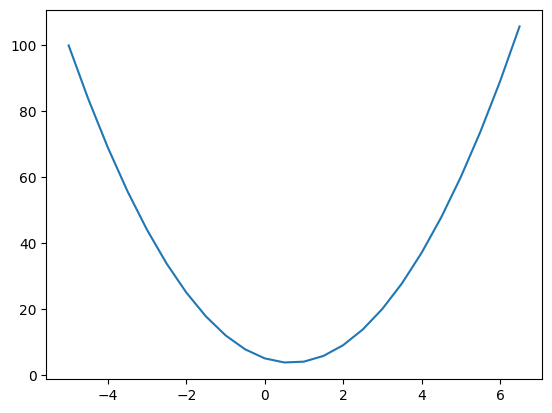

In [4]:

xs = np.arange(-5, 7, 0.5)
ys = f(xs)
plt.figure()
plt.plot(xs, ys)

x1 = 3
x2 = -3
h = 0.2

In [5]:
h = 0.2
x = 3
f(x), f(x+h), (f(x+h) - f(x)) / h

(20, 22.920000000000005, 14.600000000000026)

## Micrograd

In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [7]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# set grad
# L.grad = 1
# d.grad = f.data
# f.grad = d.data
# e.grad = f.data
# c.grad = f.data
# a.grad = f.data * b.data
# b.grad = f.data * a.data

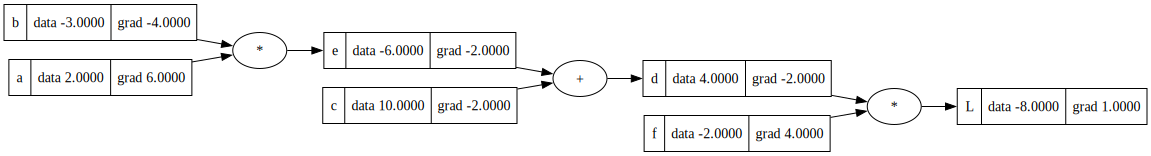

In [16]:
draw_dot(L)

In [15]:
L.backward()

In [9]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data


    print((L2 - L1)/h)

lol()

-4.000000000008441


In [10]:
# optimization
a.data += 0.0001 * a.grad
b.data += 0.0001 * b.grad
c.data += 0.0001 * c.grad
f.data += 0.0001 * f.grad

e = a * b
d = e + c
L = d * f
L.data

-7.992800640096002